Project III. 
Student: Thais Antero de Oliveira - 11138973.
Supervisor: Prof. Dr. Jackson Roehrig. 

# Watershed delineation

This script has the finality to delineate the catchment of the largest basin in a Digital Elevation Model(DEM)
as well as the subbasins relatives to the outlets points inserted (in a raster and polygon type).
Are created the flow direction raster and flow accumulation raster for the basin as well. 

In [1]:
import sys
if '../.' not in sys.path:
    sys.path.insert(0, '../.')

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from girs.rast.raster import RasterReader, RasterWriter
from girs.feat.layers import LayersReader, delete_layers
from osgeo import gdal, ogr
from pysheds.grid import Grid
from wv.wupperverband.wupperverband_konfiguration import KonfigurationWupperverband

Specifys the directional mapping

In [ ]:
#N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

In [4]:
konfiguration = KonfigurationWupperverband()

Makes the diretory (file 'delineation') to save the outputs

In [5]:
wdel = os.path.join(konfiguration.gisp_dir(), 'delineation')
os.makedirs(wdel, exist_ok=True)
wdel

'/hydropy/wvdaten/projekt/wupperverband/gis/delineation'

Saves the path in a variable for the Digital Elevation Model(DEM)

In [6]:
dgm_5 = konfiguration.dgm1.gisp_dgm1_xxm_tif(5)
dgm_5

'/hydropy/wvdaten/projekt/wupperverband/gis/dgm/dgm1/dgm1_05m_wupperverband.tif'

Defines a function to plot raster files
raster = raster variable
title = string with the title of the figure
label = string with the label for the colorbar

In [7]:
def plot(raster, title, label):
    fig, ax = plt.subplots(figsize=(8,6))
    fig.patch.set_alpha(0)
    plt.imshow(raster, extent=grid.extent, cmap='cubehelix', zorder=1)
    plt.colorbar(label=label)
    plt.grid(zorder=0)
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.tight_layout()

# DEM conditioning

Reads the DEM to grid class with the name 'dem' (to access it use grid.dem)

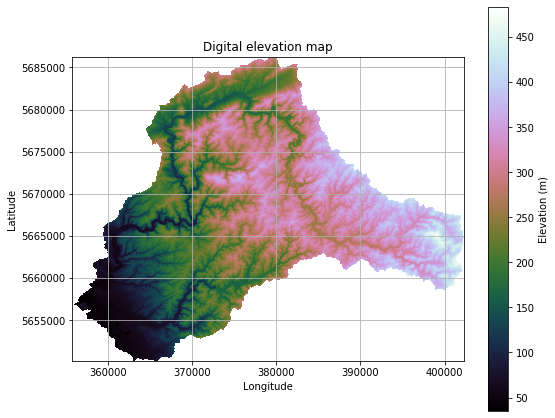

In [8]:
grid = Grid.from_raster(dgm_5, data_name='dem')
grid.set_nodata('dem', np.nan)
plot(grid.dem, title='Digital elevation map', label='Elevation (m)')

Fills the depressions (regions of cells for which every surrounding cell is at a higher elevation) in the DEM 
Saves the output with the name 'flooded_dem' (to access it use grid.flooded_dem)
Writes the Flooded digital elevation map in the same directory of the DEM as a GTiff file with the name 'flooded_dem.tif'

/home/roehrig/anaconda3/lib/python3.7/site-packages/skimage/morphology/greyreconstruct.py:130: RuntimeWarning: invalid value encountered in greater
  elif method == 'erosion' and np.any(seed < mask):


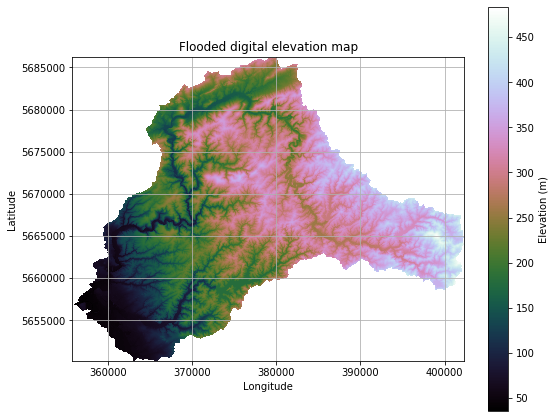

In [9]:
grid.fill_depressions('dem', out_name='flooded_dem')
_ = plot(grid.flooded_dem, title='Flooded digital elevation map', 
         label='Elevation (m)')
grid.to_raster(data_name="flooded_dem", 
               file_name=os.path.join(wdel, "flooded_dem.tif"), 
               profile={"compress":"LZW","driver":"GTiff","count":1})

Resolves the flats (cells which every surrounding cell is at the same elevation or higher). Saves the output with the name 'inflated_dem' (to access it use grid.inflated_dem). Writes the Flooded digital elevation map in the same directory of the DEM as a GTiff file with the name 'inflated_dem.tif'.

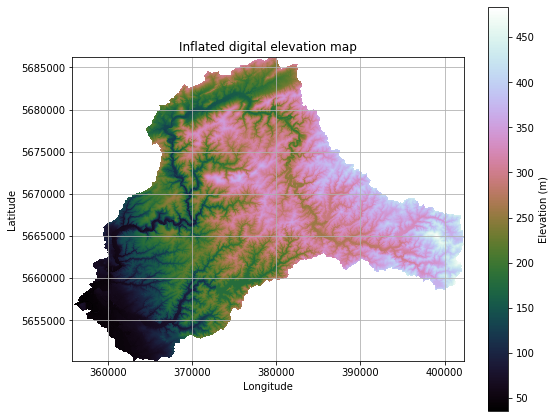

In [10]:
grid.resolve_flats('flooded_dem', out_name='inflated_dem')
plot(grid.inflated_dem, 'Inflated digital elevation map', 'Elevation (m)')
grid.to_raster(data_name="inflated_dem", 
               file_name=os.path.join(wdel, "inflated_dem.tif"), 
               profile={"compress":"LZW","driver":"GTiff","count":1})

# Flow direction

Makes each cell route to one of eight neighboring cells based on the direction of steepest descent based on the list 'dir' with the numbers representing the cardinals and intercardinals directions. Saves the output with the name 'dir' (to access it use grid.dir). Writes the grid.dir in the same file of the DEM as a GTiff file with the name 'dir.tif'

In [11]:
grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)
grid.to_raster(data_name="dir", 
               file_name=os.path.join(wdel, "dir.tif"), 
               profile={"compress":"LZW","driver":"GTiff","count":1})

# Flow accumulation

Calculates the accumulation of pixels for each cell. Saves the output with the name 'acc' (to access it use grid.acc) write the grid.acc in the same file of the DEM as a GTiff file with the name 'acc.tif'.

In [ ]:
grid.accumulation(data='dir', dirmap=dirmap, out_name='acc')
print(grid.acc.dtype)
print(grid.acc)
#grid.acc = grid.acc.astype('int32')
grid.to_raster(data_name="acc", 
               file_name=os.path.join(wdel, "acc.tif"), 
               profile={"compress":"LZW","driver":"GTiff","count":1})

Reads the grid accumulation created before. Get the parameters from the raster read. Set the nodata value. Change the data type. Write the raster with the parameters set.

In [ ]:
r = RasterReader(os.path.join(wdel, "acc.tif"))
parameters = r.get_parameters()
parameters.nodata = [-1]
parameters.data_types = [gdal.GDT_Float32]
r_out = RasterWriter(parameters, os.path.join(wdel, "acc_ln.tif"))
r_out.set_array(np.log(r.get_array()), 1)
r_out.dataset.FlushCache()
del r_out

# Catchments delineation 

## Einzugsgebiete der Pegelstationen

Reads the raster with the flow diretions.

In [6]:
grid = Grid.from_raster(os.path.join(wdel, "dir.tif"), data_name='dir')

Defines the function to transform the raster in a polygon and generate a shapefile.
src_filename = raster file name.
shp_filename = shapefile name to be saved.

In [7]:
def polygonize_tezg(src_filename, shp_filename):
    r = RasterReader(src_filename)
    nodata = r.get_nodata()
    arr = r.get_array()
    r1 = r.copy()
    r1.set_array(np.where(arr == nodata, 0, 1))
    drv = ogr.GetDriverByName("ESRI Shapefile")
    dst_ds = drv.CreateDataSource(shp_filename)
    dest_srs = ogr.osr.SpatialReference()
    dest_srs.ImportFromEPSG(3044)
    dst_layer = dst_ds.CreateLayer("TEZG", srs=dest_srs)
    srcband = r1.get_band()
    gdal.Polygonize(srcband, srcband, dst_layer, -1, [], callback=None)    

### SBEY

Delineates the catchent SBEY and save as a raster ('.tif') and as a polygon ('.shp').

In [ ]:
# Define outlet coordinates
x, y = 380952.77,5679036.79
# Define path and name of file to be saved
file_name = os.path.join(wdel, "tezg_sbey.tif")
# Delineate the catchment of the subbasin related with the outlet coordinates defined
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='tezg_sbey',
               recursionlimit=15000, xytype='label', nodata_out=0)
# Set the data type of the cells of flow direction in the delineated catchment as 32bytes interger
grid.tezg_sbey = grid.tezg_sbey.astype('int32')
# Write the raster with the subbasin name
grid.to_raster(data_name="tezg_sbey", file_name=file_name)
# Create and save the subbasin catchment as a shapefile
polygonize_tezg(file_name, '{}.shp'.format(file_name[:-4]))

### SLAA

Delineates the catchent SLAA and save as a raster ('.tif') and as a polygon ('.shp').

In [ ]:
# Define outlet coordinates
x, y = 376887.01,5679636.92
# Define path and name of file to be saved
file_name = os.path.join(wdel, "tezg_slaa.tif")
# Delineate the catchment of the subbasin related with the outlet coordinates defined
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='tezg_slaa',
               recursionlimit=15000, xytype='label', nodata_out=0)
# Set the data type of the cells of flow direction in the delineated catchment as 32bytes interger
grid.tezg_slaa = grid.tezg_slaa.astype('int32')
# Write the raster with the subbasin name
grid.to_raster(data_name="tezg_slaa", file_name=file_name)
# Create and save the subbasin catchment as a shapefile
polygonize_tezg(file_name, '{}.shp'.format(file_name[:-4]))

### SKLU

Delineates the catchent SKLU and save as a raster ('.tif') and as a polygon ('.shp').

In [ ]:
# Define outlet coordinates
x, y = 371491.6,5680062.1
# Define path and name of file to be saved
name = 'tezg_sklu'
file_name=os.path.join(wdel, "{}.tif".format(name))
# Delineate the catchment of the subbasin related with the outlet coordinates defined
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name=name,
               recursionlimit=15000, xytype='label', nodata_out=0)
# Set the data type of the cells of flow direction in the delineated catchment as 32bytes interger
grid.tezg_sklu = grid.tezg_sklu.astype('int32')
# Write the raster with the subbasin name
grid.to_raster(data_name=name, file_name=file_name)
# Create and save the subbasin catchment as a shapefile
polygonize_tezg(file_name, '{}.shp'.format(file_name[:-4]))

### SRUT

Delineates the catchent SRUT and save as a raster ('.tif') and as a polygon ('.shp').

In [ ]:
# Define outlet coordinates
x, y = 367716.90,5676902.91
# Define path and name of file to be saved
name = 'tezg_srut'
file_name=os.path.join(wdel, "{}.tif".format(name))
# Delineate the catchment of the subbasin related with the outlet coordinates defined
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name=name,
               recursionlimit=15000, xytype='label', nodata_out=0)
# Set the data type of the cells of flow direction in the delineated catchment as 32bytes interger
grid.tezg_srut = grid.tezg_srut.astype('int32')
# Write the raster with the subbasin name
grid.to_raster(data_name=name, file_name=file_name)
# Create and save the subbasin catchment as a shapefile
polygonize_tezg(file_name, '{}.shp'.format(file_name[:-4]))

### SBEC

Delineates the catchent SBEC and save as a raster ('.tif') and as a polygon ('.shp').

In [ ]:
# Define outlet coordinates
x, y = 370691.72,5671252.04
# Define path and name of file to be saved
name = 'tezg_sbec'
file_name=os.path.join(wdel, "{}.tif".format(name))
# Delineate the catchment of the subbasin related with the outlet coordinates defined
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name=name,
               recursionlimit=15000, xytype='label', nodata_out=0)
# Set the data type of the cells of flow direction in the delineated catchment as 32bytes interger
grid.tezg_sbec = grid.tezg_sbec.astype('int32')
# Write the raster with the subbasin name
grid.to_raster(data_name=name, file_name=file_name)
# Create and save the subbasin catchment as a shapefile
polygonize_tezg(file_name, '{}.shp'.format(file_name[:-4]))

### SESH

Delineates the catchent SESH and save as a raster ('.tif') and as a polygon ('.shp').

In [ ]:
# Define outlet coordinates
x, y = 370461.87,5666818.54
# Define path and name of file to be saved
name = 'tezg_sesh'
file_name=os.path.join(wdel, "{}.tif".format(name))
# Delineate the catchment of the subbasin related with the outlet coordinates defined
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name=name,
               recursionlimit=15000, xytype='label', nodata_out=0)
# Set the data type of the cells of flow direction in the delineated catchment as 32bytes interger
grid.tezg_sesh = grid.tezg_sesh.astype('int32')
# Write the raster with the subbasin name
grid.to_raster(data_name=name, file_name=file_name)
# Create and save the subbasin catchment as a shapefile
polygonize_tezg(file_name, '{}.shp'.format(file_name[:-4]))

### SGLU

Delineates the catchent SGLU and save as a raster ('.tif') and as a polygon ('.shp').

In [ ]:
# Define outlet coordinates
x, y = 368596.961,5666422.036
# Define path and name of file to be saved
name = 'tezg_sglu'
file_name=os.path.join(wdel, "{}.tif".format(name))
# Delineate the catchment of the subbasin related with the outlet coordinates defined
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name=name,
               recursionlimit=15000, xytype='label', nodata_out=0)
# Set the data type of the cells of flow direction in the delineated catchment as 32bytes interger
grid.tezg_sglu = grid.tezg_sglu.astype('int32')
# Write the raster with the subbasin name
grid.to_raster(data_name=name, file_name=file_name)
# Create and save the subbasin catchment as a shapefile
polygonize_tezg(file_name, '{}.shp'.format(file_name[:-4]))

/home/roehrig/anaconda3/envs/wvpy/lib/python3.7/site-packages/pyproj/crs.py:422: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  projstring = _prepare_from_string(projparams)
